# Metis Week 1 Challenge 1

**Objective:**   

**Background:**   

**Data:**   

All data was pulled from http://web.mta.info/developers/turnstile.html. Column details are below.   

* c_a = Control Area name/Booth name. This is the internal identification of a booth at a given station    
    
    
* unit = Remote unit ID of station 
  
  
* scp = Subunit/Channel/position represents a specific address for a given device  
  
  
* station = Name assigned to the subway station by operations planning. This name is used in all references to stations, as well as in debit/credit purchase receipts, and customer’s bank activity statements.  
  
    
* linename = Train lines stopping at this location. Can contain up to 20 single character identifier. When more than one train line appears, it is usually intercepting train lines, in major stations where the passenger can transfer between any one of the lines.  
  
  
* division = Represents the Line originally the station belonged to BMT, IRT, or IND. Each section of the system is assigned a unique line name, usually paired with its original operating company or division (Brooklyn–Manhattan Transit Corporation (BMT), Interborough Rapid Transit Company (IRT), and Independent Subway System (IND).  
  
  
* datetime = Represents the date & time of the audit data
  
  
* description = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours) 1. Audits may occur more frequently than 4 hours due to planning, or troubleshooting activities. 2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. If a recovered audit is sent and is identical to the previous register reading, it will be omitted.  
  
  
* entries = The cumulative ENTRY register value for a device. This register was initialized during system setup. It is a 10 digit number representing the number of entries on the specific device since its inception. Other forms of initialization may occur upon roll-over of the counter, erasing the memory device containing the register data, and replacing the processing device of the turnstile.  
  
  
* exits = The cumulative EXITS register value for a device. This register was initialized during system setup. It is a 10 digit number representing the number of entries on the specific device since its inception. Other forms of initialization may occur upon roll-over of the counter, erasing the memory device containing the register data, and replacing the processing device of the turnstile.

******

## Challenge 1
Open up a new IPython notebook
Download a few MTA turnstile data files
Load the files into a pandas DataFrame (hint: pd.read_csv() to load files and pd.concat() to combine DataFrames)

In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
%matplotlib inline

In [482]:
may_4_2019 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190504.txt')
may_11_2019 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190511.txt")
may_18_2019 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190518.txt")
may_25_2019 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190525.txt")

mta_data = pd.concat((may_4_2019, may_11_2019, may_18_2019, may_25_2019), axis=0)

In [483]:
mta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822989 entries, 0 to 203362
Data columns (total 11 columns):
C/A                                                                     822989 non-null object
UNIT                                                                    822989 non-null object
SCP                                                                     822989 non-null object
STATION                                                                 822989 non-null object
LINENAME                                                                822989 non-null object
DIVISION                                                                822989 non-null object
DATE                                                                    822989 non-null object
TIME                                                                    822989 non-null object
DESC                                                                    822989 non-null object
ENTRIES                           

In [484]:
mta_data.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [485]:
#updating column names to remove spaces, capitalization, and slashes
mta_data.columns = mta_data.columns.str.lower().str.strip().str.replace('/', '_')
mta_data.columns

Index(['c_a', 'unit', 'scp', 'station', 'linename', 'division', 'date', 'time',
       'desc', 'entries', 'exits'],
      dtype='object')

In [486]:
mta_data.describe()

,entries,exits
count,8.229890e+05,8.229890e+05
mean,4.137444e+07,3.392040e+07
std,2.110233e+08,1.945992e+08
min,0.000000e+00,0.000000e+00
25%,3.552810e+05,1.453550e+05
50%,2.179688e+06,1.249356e+06
75%,6.796341e+06,4.610048e+06
max,2.129343e+09,2.124127e+09


******

## Challenge 2
Let's turn this into a time series.

Our pandas dataframe has columns called Date and Time (what datatype did pandas assign to these columns on import?), however in python and pandas we can convert date and time information to datetime objects, which allow us to do time-based operations

Using either pd.to_datetime in pandas or the python datetime library, combine the Date and Time columns into a single new column of the datetime datatype

In [487]:
mta_data['datetime'] = mta_data['date'] + mta_data['time']
mta_data['datetime'] = pd.to_datetime(mta_data['datetime'], format=('%m/%d/%Y%H:%M:%S'))
mta_data = mta_data.drop(columns=['date', 'time'])

In [488]:
mta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822989 entries, 0 to 203362
Data columns (total 10 columns):
c_a         822989 non-null object
unit        822989 non-null object
scp         822989 non-null object
station     822989 non-null object
linename    822989 non-null object
division    822989 non-null object
desc        822989 non-null object
entries     822989 non-null int64
exits       822989 non-null int64
datetime    822989 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 69.1+ MB


******

## Challenge 3
Each row is a turnstile, identified by a combination of the C/A, UNIT, SCP, and STATION columns, with information on entries and exits at that turnstile every n hours. (What is n?) We want total daily entries.
Group the data so that it represents daily entries for each turnstile (hint: pd.groupby or DataFrame.groupby)

In [489]:
station_turnstile_date_grouped = mta_data.groupby(
    ['c_a', 
     'unit',
     'scp', 
     'station', 
     mta_data.datetime.dt.date
    ])['entries'].min().reset_index()

station_turnstile_date_grouped['daily_entries'] = station_turnstile_date_grouped.groupby(['c_a', 'unit', 'scp', 'station'])['entries'].diff().shift(-1)

This method works for calculating the majority of the daily_entries values but poses a challenges at the group edges. The last row of each group is calculated as the difference between the last row of that group and the first row of the next group causing grossly inaccurate values for daily_entries at the edges. The issue impacts roughly the bottom 3% and up to the top 2% of the data (this also includes any other outliers).  

Additionally, random negative values pop up when a turnstile is reset. We know that a turnstile cannot have any a negative number of uses so any row with daily_entries values below 0 is invalid.  

As a result, any row with daily_entries values less than 0 should be dropped. Then the top values should be reassessed. 

In [490]:
station_turnstile_date_grouped.describe([.03,.75,.999])

,entries,daily_entries
count,1.351040e+05,1.302340e+05
mean,4.113630e+07,3.646634e+04
std,2.105842e+08,9.600477e+06
min,0.000000e+00,-1.437240e+09
3%,1.000000e+01,0.000000e+00
50%,2.151313e+06,7.940000e+02
75%,6.751859e+06,1.583000e+03
99.9%,2.029756e+09,7.164301e+03
max,2.129342e+09,2.055526e+09


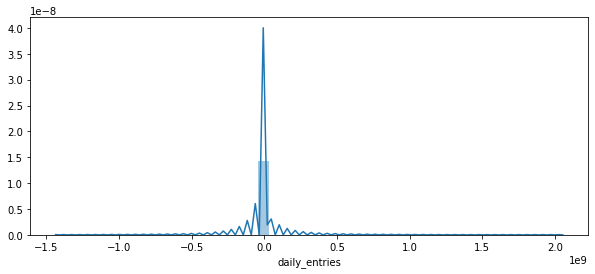

In [491]:
station_turnstile_date_grouped_reset = station_turnstile_date_grouped.reset_index()
stdg_daily_entries_series = station_turnstile_date_grouped_reset[station_turnstile_date_grouped_reset.daily_entries.notnull()]

plt.figure(figsize=(10,4))
sns.distplot(stdg_daily_entries_series.daily_entries)

In [494]:
to_drop = station_turnstile_date_grouped[station_turnstile_date_grouped.daily_entries < 0]
to_drop

,c_a,unit,scp,station,datetime,entries,daily_entries


In [493]:
station_turnstile_date_grouped.drop(to_drop.index, inplace=True)

In [503]:
station_turnstile_date_grouped.describe()

,entries,daily_entries
count,1.338050e+05,1.289350e+05
mean,3.073199e+07,6.115991e+04
std,1.701864e+08,8.387366e+06
min,0.000000e+00,0.000000e+00
25%,3.320440e+05,2.640000e+02
50%,2.113802e+06,8.070000e+02
75%,6.505657e+06,1.593000e+03
max,2.129289e+09,2.055526e+09


In [511]:
top_vals = station_turnstile_date_grouped.daily_entries.quantile(q=.997)
to_drop_high_end = station_turnstile_date_grouped[station_turnstile_date_grouped.daily_entries > to_drop_high_end]
station_turnstile_date_grouped.drop(to_drop_high_end.index, inplace=True)

In [512]:
station_turnstile_date_grouped.describe()

,entries,daily_entries
count,1.334180e+05,128548.000000
mean,3.073163e+07,1050.453799
std,1.702762e+08,988.355511
min,0.000000e+00,0.000000
25%,3.303192e+05,262.000000
50%,2.110156e+06,803.000000
75%,6.490528e+06,1584.000000
max,2.129289e+09,5720.000000


Once we drop the rows with daily_entries values that are less than zero, we can see that there are still a few outliers that are likely due to error or the edge cases described above. The top 1% should be removed as well. 

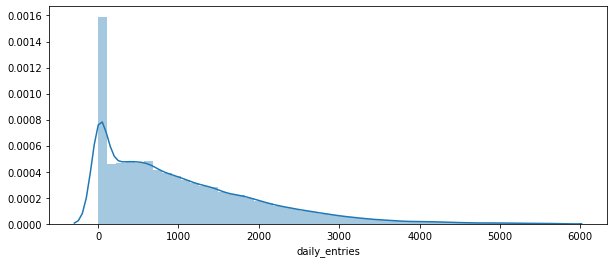

In [513]:
station_turnstile_date_grouped_reset = station_turnstile_date_grouped.reset_index()
stdg_daily_entries_series = station_turnstile_date_grouped_reset[station_turnstile_date_grouped_reset.daily_entries.notnull()]

plt.figure(figsize=(10,4))
sns.distplot(stdg_daily_entries_series.daily_entries)

******

## Challenge 4
We will plot the daily time series for a single turnstile.

Select one turnstile (combination of [C/A, UNIT, SCP, STATION])
Filter your pandas DataFrame so it only represents a single turnstile (make sure that turnstile has entries for multiple days).
Using matplotlib, create a plot with the days on the X axis and the daily entries for that turnstile on the Y axis
You can use the following as a starting point:

    plt.figure(figsize=(10,3))
    plt.plot(<days>,<entries>)

In [514]:
station_turnstile_date = station_turnstile_date_grouped.reset_index()
station_turnstile_date

,index,c_a,unit,scp,station,datetime,entries,daily_entries
0,0,A002,R051,02-00-00,59 ST,2019-04-27,7035249,851.0
1,1,A002,R051,02-00-00,59 ST,2019-04-28,7036100,646.0
2,2,A002,R051,02-00-00,59 ST,2019-04-29,7036746,1496.0
3,3,A002,R051,02-00-00,59 ST,2019-04-30,7038242,1487.0
4,4,A002,R051,02-00-00,59 ST,2019-05-01,7039729,1574.0
...,...,...,...,...,...,...,...,...
133413,135099,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-05-20,5554,0.0
133414,135100,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-05-21,5554,0.0
133415,135101,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-05-22,5554,0.0
133416,135102,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-05-23,5554,0.0


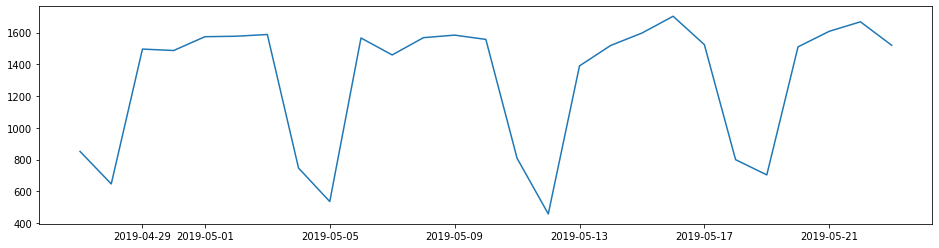

In [515]:
station_turnstile_date = station_turnstile_date_grouped.reset_index()
single_turnstile = station_turnstile_date[
    (station_turnstile_date['c_a'] == 'A002') & 
    (station_turnstile_date['unit'] == 'R051') & 
    (station_turnstile_date['scp'] == '02-00-00')  & 
    (station_turnstile_date['station'] == '59 ST')
    ].groupby(["datetime"]).daily_entries.max()

plt.figure(figsize=(16,4))
plt.plot(single_turnstile);

******

## Challenge 5
So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstiles-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.
We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, sum the counts from each turnstile belonging to that combo. (hint: pd.groupby)

In [516]:
grouped_by_st_ca_unit = station_turnstile_date.groupby(['c_a', 'unit', 'station', 'datetime']).daily_entries.agg({'daily_entries': 'sum'})
grouped_by_st_ca_unit.head()

/Users/mollyliebeskind/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


daily_entries
c_a  unit station datetime                 
A002 R051 59 ST   2019-04-27         8394.0
                  2019-04-28         6337.0
                  2019-04-29        13132.0
                  2019-04-30        13664.0
                  2019-05-01        13748.0

******

## Challenge 6
Similarly, combine everything in each station, and come up with daily time series for each STATION, by adding up all the turnstiles in a station.

In [517]:
grouped_by_station = station_turnstile_date.groupby(['station', 'datetime']).daily_entries.agg({'daily_entries': np.sum})
grouped_by_station.head()

/Users/mollyliebeskind/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


daily_entries
station datetime                 
1 AV    2019-04-27         6338.0
        2019-04-28         4555.0
        2019-04-29        18018.0
        2019-04-30        18923.0
        2019-05-01        19226.0

******

## Challenge 7
Plot the daily time series for a station.

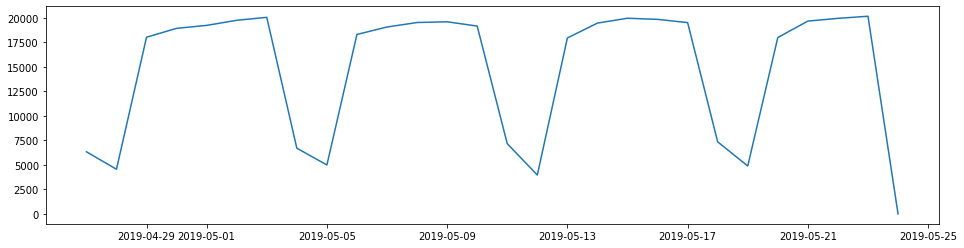

In [519]:
reset_index_station = grouped_by_station.reset_index()

single_station= reset_index_station[reset_index_station['station'] == '1 AV'
    ].groupby(["datetime"])['daily_entries'].agg(['max'])

plt.figure(figsize=(16,4))
plt.plot(single_station);

In [520]:
unique_stations = reset_index_station.station.unique()

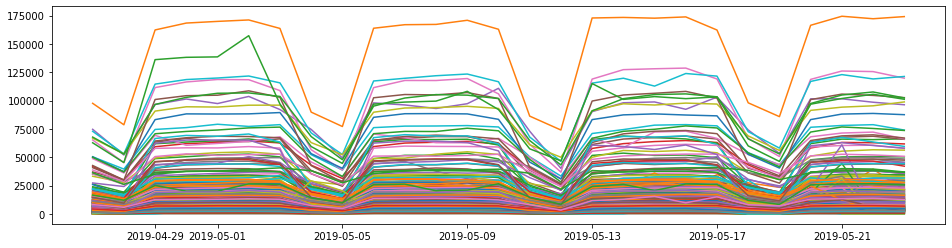

In [523]:
plt.figure(figsize=(16,4))

for station in unique_stations:
    single_station= reset_index_station[reset_index_station['station'] == station
    ].groupby(["datetime"])['daily_entries'].agg(['max'])
    plt.plot(single_station[:-1]);


In [522]:
reset_index_station.sort_values(by='daily_entries', ascending=False).head(10)

,station,datetime,daily_entries
1730,34 ST-PENN STA,2019-05-21,174371.0
1732,34 ST-PENN STA,2019-05-23,174060.0
1725,34 ST-PENN STA,2019-05-16,173787.0
1723,34 ST-PENN STA,2019-05-14,173332.0
1722,34 ST-PENN STA,2019-05-13,172839.0
1724,34 ST-PENN STA,2019-05-15,172665.0
1731,34 ST-PENN STA,2019-05-22,172172.0
1711,34 ST-PENN STA,2019-05-02,171091.0
1718,34 ST-PENN STA,2019-05-09,170815.0
1710,34 ST-PENN STA,2019-05-01,169831.0


******

## Challenge 8
Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. (hint: pandas datetime day of week may be useful)
plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [349]:
reset_index_station.datetime.dt.dayofweek()

AttributeError: Can only use .dt accessor with datetimelike values

In [160]:
reset_index_station['dow'] = reset_index_station.datetime.dt.dayofweek

AttributeError: Can only use .dt accessor with datetimelike values

In [146]:
single_station.groupby(datetime)
days_of_week = ["mon", "tues"]
ls_1 = [monday_entries, tuesday_entries, wednesday_entries]
ls_2 = [monday_entries, tuesday_entries, wednesday_entries]


for row in single_station.index:
    if row.dt.dayofweek == 6:
        


,max
datetime,
2019-04-27,6338.0
2019-04-28,4555.0
2019-04-29,18018.0
2019-04-30,18923.0
2019-05-01,19226.0


In [157]:
single_station['day_of_week'] = 

,max
datetime,
2019-04-27,6338.0
2019-04-28,4555.0
2019-04-29,18018.0
2019-04-30,18923.0
2019-05-01,19226.0


******

## Challenge 9
Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

******

## Challenge 10
Make a single list of these total ridership values and plot it with

plt.hist(total_ridership_counts)

to get an idea about the distribution of total ridership among different stations.

This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

Additional Hint:

If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a plt.bar graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be 0,1,2,3,..., so you can do

indices = range(len(total_ridership_values))
plt.bar(indices, total_ridership_values)

## Storing for later

In [209]:
#grouped_by_date = mta_data.groupby(['c_a', 'unit', 'scp', 'station', mta_data.datetime.map(lambda x: x.strftime('%Y-%m-%d'))])['entries', 'exits'].min()
#grouped_by_date['entries_per_day'] = np.NaN
#for i, val in enumerate(grouped_by_date.index[:-1]):
 #       if grouped_by_date.index[i][0:4] == grouped_by_date.index[i+1][0:4]:
  #          grouped_by_date.iloc[i, 2] = int((grouped_by_date.iloc[(i+1),0] - grouped_by_date.iloc[i,0]))
   #     else: 
    #        continue

In [371]:
station_locations_data = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [375]:
station_locations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 13 columns):
Station ID               496 non-null int64
Complex ID               496 non-null int64
GTFS Stop ID             496 non-null object
Division                 496 non-null object
Line                     496 non-null object
Stop Name                496 non-null object
Borough                  496 non-null object
Daytime Routes           496 non-null object
Structure                496 non-null object
GTFS Latitude            496 non-null float64
GTFS Longitude           496 non-null float64
North Direction Label    478 non-null object
South Direction Label    481 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 50.5+ KB


In [403]:
unique_stations_in_mta = mta_data.station.unique()
unique_stations_in_mta[:10]

array(['59 ST', '5 AV/59 ST', '57 ST-7 AV', '49 ST', 'TIMES SQ-42 ST',
       '34 ST-HERALD SQ', '28 ST', '23 ST', '14 ST-UNION SQ', '8 ST-NYU'],
      dtype=object)

In [407]:
unique_stations_inlocations = station_locations_data['Stop Name'].unique()
unique_stations_inlocations[:10]

array(['Astoria - Ditmars Blvd', 'Astoria Blvd', '30 Av', 'Broadway',
       '36 Av', '39 Av', 'Lexington Av/59 St', '5 Av/59 St',
       '57 St - 7 Av', '49 St'], dtype=object)

**NEED TO REPLACE COLUMNS WITH SAME CASES THEN RUN BELOW**

In [409]:
in_both = [x for x in unique_stations_in_mta if x in unique_stations_inlocations]
mta_only = [x for x in unique_stations_in_mta if x not in unique_stations_inlocations]
locations_only = [x for x in unique_stations_inlocations if x not in unique_stations_in_mta]

other mta data from this site: http://web.mta.info/developers/developer-data-terms.html#data